# Copper wire heating - 'Hello World!' example
***
***

<img src="fig/copper_wire.png" alt="Hello copper wire!" width="600"/>

## Physical formulation

---
Let us consider a thermally insulated cooper wire $\Omega$ of length $L$ and radius $R$ with a straight centerline whose direction coincides with the $+x$-axis.
The wire is subject to a voltage drop $U$ connecting a heat pump control unit, which is located in a house cellar with the temperature $T_\mathrm{c}$, with an external heat exchanger located outside at the ambient air temperature $T_\mathrm{h}$.
Our goal is to compute the equilibrium temperature distribution of the wire for the given parameters.

In [167]:
%load_ext tikzmagic

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


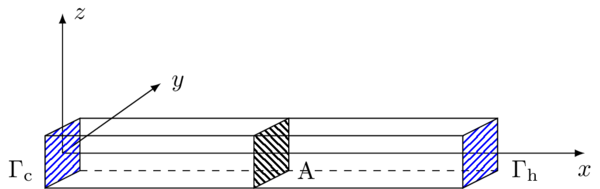

In [168]:
%%tikz -l patterns -s 600,320
\input{fig/formulation.tikz};

---

## Mathematical formulation

---
### Governing equations
The problem is governed by the principle of energy conservation, which for continuous material takes the form<a id='governing_eqns'></a>
\begin{align*}
	\text{div}\, \mathbf{q} &= b && \text{in } \Omega\,,
\end{align*}
where
\begin{align*}
	\mathbf{q}:\Omega \to \mathbb{R}^3
\end{align*}
denotes the heat flux,
and $b$ is the volumetric (internal) heat source, whose power is, in this case, given by Joule's law, meaning $b = (\pi R ^2 U)^2/\rho$, with $\rho$ being the electrical resistivity of the material filling $\Omega$. Assuming the Fourier law, $\mathbf{q} = - k \nabla T$, the governing equation yields the (equilibrium) heat equation
\begin{align*}
	-\Delta T &= \frac{b}{k} && \text{in } \Omega\,, \\
	T &= T_\mathrm{c} && \text{on } \Gamma_{\text{c}}\,, \\
	T &= T_\mathrm{h} && \text{on } \Gamma_{\text{h}}\,, \\
    \mathbf{q} \cdot \mathbf{n} &= 0 && \text{on } \partial \Omega\setminus\{\Gamma_{\text{h}} \cup \Gamma_{\text{h}}\}\,,
\end{align*}
where we assumed the heat conductivity $k$ to be constant in the whole domain $\Omega$.

### One-dimensional formulation
Making use of<ul><li>the (rotational) symmetry of the problem</li>
    <li>insulation of the wire, i.e., $\mathbf{q} \cdot \mathbf{n} = 0 \text{ on } \partial \Omega\setminus\{\Gamma_{\text{h}} \cup \Gamma_{\text{h}}\}$</li>
    <li>properties uniform over the cross-section</li></ul>the problem can be simplified and approached as essentially one-dimensional. Consequently, we solve the following boundary value problem
\begin{align*}
	-T'' &= \frac{b}{k} && \text{in } \Omega = (0,L)\,, \\
	T(0) &= T_\mathrm{c}\,, \\ T(L) &= T_\mathrm{h}\,.
\end{align*}
Though this formulation denotes the starting point of an effective numerical solution of the problem, the finite element method, which provides the mathematical bedrock of the FEniCS computational platform, assumes a different, more general, formulation, the so-called [weak formulation](#weak_form), which will be detailed later.

---

## FEniCS Implementation

---
Having clarified the basic formulation of the problem, we can start implementing it in FEniCS.
First of all, we must import the ``fenics`` library into the ``python`` interface. Moreover, we import the ``pyplot`` library that is used for graph rendering.
Finally, we will also need some features of the ``numpy`` package.

In [169]:
# Import relevant modules:

### Problem parameters
As a first step in the actual implementation, we need to specify electrical resistivity and heat conductivity of copper, our material of choice.
Following table shows also some other materials for comparison.
All the values are for the temperature around 20 °C and atmospheric pressure.

<div align = "center">
    
| Material | Electrical resistivity $\rho\ [\Omega \cdot \mathrm{m}]$ | Thermal conductivity $k\ [\mathrm{W} \cdot \mathrm{m}^{-1} \cdot \mathrm{K}^{-1}]$ |
|--------|:-------------:|:-----:|
|**Copper**|$1.68\times10^{−8}$|   $384.1$ |
| Silver |    $1.59\times10^{−8}$   |  $429$   |
| Stainless Steel  |    $69.0\times10^{−8}$   |  $16$&ndash;$20$  |
| Glass  |    $10^{11}$&ndash;$10^{15}$   |  $0.8$&ndash;$1.9$  |

</div>

It is recommended to gather all the problem parameters at the beginning of the solution script file, let us follow it by specifying the geometeric, the environment, and the material parameters.

In [170]:
# --------------------
# Parameters
# --------------------
# Geometric parameters:
L = 5.0  # Length of the wire [m]
R = ___ # Radius of the wire [m]

# Environment parameters:

# Material parameters:


### Geometry of the problem

Next, we define the discretized geometry of our problem. There is always a possibility to use an external mesh defined in an *.xml* file. In our case, we use the predefined interval mesh provided directly by FEniCS environment.
Initialization of the FEniCS object ``IntervalMesh(nx, x_1, x_2)`` creates an equidistantly discretized one-dimensional mesh with ``nx`` subintervals between the end points ``x_1`` and ``x_2``.

>You can invoke a basic description of any function/object by ``help`` command. Try that for the object ``IntervalMesh``.


In [171]:
%%capture
# %%capture supresses the output of this notebook cell, which is quite lenghty for the help command
help(fe.IntervalMesh)

In [172]:
# --------------------
# Geometry
# --------------------
nx = ___ # Number of mesh subintervals
mesh = ___

We can visually check the mesh using the FEniCS ``plot()`` command. The plot object is then displayed by adding the pyplot command ``show()``.

In [ ]:
fe.plot(mesh)
plt.show() # this forces the plot to show in a pop-up window when in command line/script environment

### Weak formulation

As was said previously, any sensible nemerical simulation of a problem starts with its mathematical formulation, typically in the form of a PDE.
This is sometimes called a classical formulation.
Now more specifically, any finite element method computation starts with the so-called weak formulation of the problem, which stems from the PDE governing the problem, but should be understood rather as its generalization.
One of the very nice features of FEniCS is that the implementation of the weak form closely imitates its (written) mathematical form.
The weak formulation<a id='weak_form'></a> of our problem reads

\begin{align*}
	\text{look for } T \in V: a(T,\vartheta) = \mathscr{l}(\vartheta), \quad \forall \vartheta \in V\,,
\end{align*}

where $T(x)$ represents our weak solution, that is, the temperature field, $\vartheta(x)$ is the so-called test function, 

\begin{align*}
	a(T,\vartheta) = \int_0^L T'(x) \vartheta'(x)\, \text{d} x
\end{align*}

is the bilinear form, that is a mapping $a: V \times V \rightarrow \mathbb{R}$ linear in both of its arguments, and

\begin{align*}
	\mathscr{l}(\vartheta) = \int_0^L  \frac{A^2 U^2}{\rho k} \vartheta(x)\, \text{d} x
\end{align*}

is the linear functional defined on $V$, which represents some linear space containing all the possible (weak) solutions to our problem[<sup>1</sup>](#fn1 "Definition of Sobolev space").
Since the space $V$ might be infinite dimensional, a crucial step of any numerical method, which begins with such formulation, is to approximate $V$ using some smaller, i.e., finite-dimensional, space $V_h$.
The hallmark of FEM is that it uses piece-wise polynomial functions for the definition of $V_h$.

#### Function spaces definition
Thus the first step in our FEniCS implementation of the finite element formulation is to define the proper function space approximation $V_h$ that contains the piece-wise polynomial solution and test functions. 
This is done by initializing the object ``FunctionSpace(mesh,type,deg)`` with three arguments.  
The first argument is the discretized domain contained in the ``mesh`` variable.
Second and third are the type ``type`` of the base functions and the order ``deg`` of these functions respectively.
We will present various types of function elements throughout this course.
You can check an encyclopaedia of finite elements e.g., [here](https://defelement.com/).
In this simple setting, we define the conforming space of finite elements, i.e., $V \subset V_h$, or more specifically the *Lagrange/Continous Galerkin* element (hence the acronym ``CG``) of order one, in other words, piecewise linear functions.

<span id='fn1'><sup>1</sup>It is the result of functional analytic approach to the theory of PDEs that such object is the [Sobolev space](https://en.wikipedia.org/wiki/Sobolev_space#One-dimensional_case) $H^1_0 = \{ v \in H^1(0,L); v(0) = v(L) = 0\}$.
Further it holds that $H^1(0,L) \subset AC[0,L]$ (which denotes the space of [absolutely continuous](https://en.wikipedia.org/wiki/Absolute_continuity#Definition) functions on $[0,L]$) meaning that it makes sense to use point-wise of the functions.</span>

In [174]:
# ---------
# FE spaces
# ---------


Then, we need to initialize the solution and test functions (specified by the definition of $V_h$) as ``TrialFunction`` and ``TestFunction`` objects, respectively.

In [175]:
# Definition of trial (=solution) and test functions:


#### Boundary conditions
As this next step, we specify the geometric boundary of the domain through which we apply the Dirichlet boundary conditions.
It is necessary to mark those entities of the mesh that constitute the boundaries $\Gamma_{\text{D}}$ and $\Gamma_{\text{N}}$.
This can be done essentially in two ways.

In [176]:
# ------------------------
# Boundary markings
# ------------------------


In the previous, ``on_boundary`` flag is ``True`` for all points that lie on the boundary of the mesh and ``near(x,x0)`` checks whether ``x`` is close to&nbsp;``x0`` (by default, within the tolerance given by the global constant ``DOLFIN_EPS``), which respectively gives the left and the right end of the beam.
  
>When you compare two real numbers in ``python``, always use certain **tolerance**. Value of the tolerance depends on the size of the numbers you compare. For unit sized numbers, ``DOLFIN_EPS = 3e-16`` is sufficient.  

Try it for yourselves. Print the outcomes e.g., of ``0.1+0.1+0.1-0.3`` and ``100.1+100.1+100.1-300.3``:

In [177]:
print(0.1+0.1+0.1-0.3)
print(100.1+100.1+100.1-300.3)

5.551115123125783e-17
-5.684341886080802e-14


There is an equivalent way of marking the boundary. It employs the ``MeshFunction`` object that represents a numerically/Boolean valued function defined on the mesh. More precisely, the first argument in initialization can either be ``‘int’``, ``‘size_t’``, or ``‘double’``, which denotes the integers, unsigned integers and floats, respectively. The Boolean valued function is initialized with the ``‘bool’`` argument.

The previous ``for`` loop iterates through facets of the mesh (vertices in our example) and assigns the value one to the left boundary and the value two to the right boundary of the bar.

>note: it is preferable to set some default numerical value (e.g., zero) to all the other mesh facets, this can be done either by giving the last optional argument ``0`` in the initialization of the ``MeshFunction`` object or by calling ``boundary.set_all(0)`` **before** the ``for`` loop

Though from the perspective of physics there are many boundary conditions (depending on what type of problem we solve), mathematically speaking all of the standard boundary conditions fall into one of the three following categories.

##### 1. Dirichlet boundary conditions

The first type of boundary conditions is the one that prescribes some value of the solution at the boundary.
With heat transfer problems, this constitutes the case when the boundary is held at a constant temperature, e.g., by a large reservoir of water.

> note: In the realm of variational, or weak formulations of PDEs, the Dirichlet boundary conditions are sometimes called **essential**, since they determine the definition of the solution function space.

In FEniCS, Dirichlet boundary conditions are implemented through the object ``DirichletBC`` initialized with three arguments: the function space, the prescribed value at the boundary, and the corresponding subdomain specified by the previously defined ``left`` function (or equivalently by the ``boundary`` variable and its numerical value at the desired facets).

In [179]:
# --------------------
# Boundary conditions
# --------------------
bc_left = ___ # prescribe cellar temperature to the left end of the wire
bc_right = ___ # prescribe outdoor temperature to the right end of the wire

# Group boundary conditions into an array:

# Equivalently, using boundary variable:
#bc_left = fe.DirichletBC(V_h, T_c, boundary, 1)
#bc_right = fe.DirichletBC(V_h, T_h, boundary, 2)

##### 2. Neumann boundary conditions
The second type of boundary conditions specifies the value of the solution's normal derivative across the boundary.
For our physical problem, this means that the heat flux over the boundary is given by prescribed rate $g$, i.e.,

\begin{align*}
	\mathbf{q} \cdot \mathbf{n} = -k \frac{\partial T}{\partial n} = g\,,
\end{align*}

where $\mathbf{n}$ denotes the outer unit normal (in our case $-1$ for the boundary $x = 0$ and $+1$ for $x = L$), and $g>0$ some given heat inflow through boundary.

>note: The category of Neumann boundary conditions is sometimes denoted as natural. The natural boundary conditions are reflected directly in the weak formulation of the problem.
 
In the [weak formulation](#weak_form) above, the Neumann boundary condition would appear as a term from the integration by parts formula. To include this term in our implementation of the problem, we would first need to define the integrating measures that correspond to the boundary manifold of the mesh. To this end, we could initialize the ``Measure`` object with input arguments: string that specifies the integral type, ``"dx"`` for volume, ``"ds"`` for surface integral, and the respective geometry to which the measure corresponds, ``mesh`` for volume, ``boundary`` for surface integral.

In [180]:
# Define volume and surface measures:


##### 3. Newton-Robin boundary conditions
The last class of boundary conditions represents a linear combination of the two previous kinds.
Therefore both the solution's value and its normal derivative are prescribed, mathematically

\begin{align*}
	aT + b \frac{\partial T}{\partial n} = g\,,
\end{align*}

where $a, b \in \mathbb{R}$ are arbitrary constants (weights).
As the name might suggest, the convective heat transfer (Netwon's law of cooling) can be described by this type of boundary condition.
Namely

\begin{align*}
	\mathbf{q} \cdot \mathbf{n} = -k \frac{\partial T}{\partial n} = r\,(T_\infty - T)\,,
\end{align*}

where $r$ denotes the coefficient of heat transfer and $T_\infty$ is the ambient temperature.

#### Discretized weak formulation and problem form

We are now ready to give the weak form of the problem. One of the very nice features of FEniCS is that the implementation closely imitates the [weak formulation](#weak_form) given above.
Weak formulation<a id='weak_form'></a> is

\begin{align*}
	T - T_\mathrm{b} \in V_h: \sum_{i=1}^n\int_{x_{i-1}}^{x_i} T'(x) \vartheta'(x)\, \text{d} x = \sum_{i=1}^n\int_{x_{i-1}}^{x_i} \frac{A^2 U^2}{\rho k} \vartheta(x)\, \text{d} x, \quad \forall \vartheta \in V_h\,,
\end{align*}

where $V_h = \{ v \in C([0,L]); v(0) = v(L) = 0, v|_{[x_{i-1}, x_i]} \in P^1\}$, and $T_\mathrm{b}$ is some particular solution that respects the boundary conditions, e.g., linear temperature distribution.

In [181]:
# --------------------
# Weak form
# --------------------
a = ___
l = ___

We need to supply the subdomain measure ``ds`` with the value of the ``MeshFunction`` object that corresponds to the Neumann part of the boundary $\Gamma_{\text{N}}$, i.e., two.

>*note*: it is possible to access individual elements of the gradient ``grad`` of a function ``u`` via ``u.dx(i)``, where ``i`` specifies the derivative with respect to the ``i``-th coordinate and the enumeration starts with **zero**, do not confuse this with the measure object ``dx`` that specifies the integration domain

>``dot(u,v)`` vs ``inner(u,v)``: FEniCS makes distinction between the inner product and dot product of two elements ``u``, ``v``, ``dot(u,v)`` contracts (sums) over the last index of the first element and the first index of the second element, whereas ``inner(u,v)`` sums over all indices of the elements that must be of the same order

* if ``u``, ``v`` are both vectors (rank 1 tensor), then ``dot(u,v)=inner(u,v)``
* matrix-vector multiplication $\sigma \mathbf{n}$ is computed using ``dot(sigma,n)``

Finally, we call the solver to compute the linear algebraic system generated by the finite element method. FEniCS is prompted to do that by calling the ``solve()`` function supplied with three parameters: linear variational equation, function that will store the resulting approximation and the problem specific Dirichlet boundary conditions.

Let us first introduce the function ``u`` that will contain the finite element solution. In the code environment we define the object ``Function`` pertaining to the function space $V_h$. Then we can call ``solve(a==l, u, bc)``.

In [182]:
# --------------------
# Solver
# --------------------


## Post processing

---

There is more than one way of visualizing results from FEniCS computations, the readily available one is the tools offered by ``matplotlib`` library

### Graphing with ``matplotlib``
In the final stage of our simulation we visualize the computational results. This task is easily handled by the ``matplotlib`` library that we imported at the beginning and already used for mesh visualization.

In [ ]:
# --------------
# Postprocessing
# --------------

# Define exact solution:

# Graph solutions:


### Benchmarking results

For many trivial problems, ours included, there is an exact solution. We can use this solution to benchmark our numerical results. The previous cell introduced the visual comparison of the explicit and discretized solutions.
To make the benchmarking process quantitative, we use FEniCS' ``errornorm`` functionality.
In order to benchmark the explicit solution, we first need to represent as an object that FEniCS can handle. Basically, there are two objects in the ``fenics`` library that are expedient to our goal.

> **Expression** vs. **UFL**. FEniCS object ``Expression`` can be understood as an entity containing *precise* representation of some mathematical formula (e.g., the function $\sin(x)$), whereas UFL obejct is essentialy representation of that said formula that belongs to the finite element space $V_h$.
It is worth noting that anytime you want to work with expressions within the framework of FEM, you need to modify them so that they, again, belong to $V_h$.
This can also be done in two ways.

> ``project`` vs ``interpolate``. The result of ``interpolate`` is, simply put, a FE element function from V_h, that coincides with the original object in the nodes of the finite element (in our case of piece-wise linear functions, these are endpoints of every subinterval).
``projection`` on the other hand does not have to coincide in the nodal points, but it is in some sense the best approximation to the original object that lies in $V_h$.
More precisely it the result of the orthogonal projection of the object onto $V_h$, mathematically it is a function u_h \in V_h that satisfies
\begin{align*}
\int_\Omega (u_h - \sin(x))v_h\,\mathrm{d}x = 0\,, \forall v_h \in V_h\,.
\end{align*}

In [184]:
# Define expression containg the explicit solution:
T_sol = fe.___("-U*U*A*A/(2.0*rho*k)*x[0]*x[0] + ((T_h - T_c)/L + U*U*A*A/(2*rho*k)*L)*x[0] + T_c",
                      U = U, A = A, rho = rho, k = k, T_h = T_h, T_c = T_c, L = L,
                     ___)

#T_sol_prj = fe.project(T_sol, V_h)

# It is recommended to use a finer mesh for comparison:

err = ___

2.5805735030741737


## Questions and excercises

---

Q.1 Are all the properties and variables really constant over the cross-section? Is the one-dimensional simplication justified?
<br/>Q.2 Consider the wire to be thermally insulated on both ends, i.e., $\partial T/\partial x(0) = \partial T/\partial x(L) = 0$, is such problem well defined? If not, how can we make it so?

E.1 Study the role of finite element degree, possibly on some coarse mesh. What should the graph of the solution look like? Based on the values of the error is it more efficient to raise degree of the finite element, or the number of the mesh nodes?
<br/>E.2 Assume that the control unit (and effectively the left end of the wire) is cooled by a fan blowing air at the temperature $T_0$, formulate the problem with this boundary condition.
<br/>E.3 Try to the implement and test the formulation from Q.2.
<br/>E.4 Study the difference between projection and interpolation on the step function $$f(x) = \begin{cases} 0 & x <0 \\ 1/2 & x= 0 \\ 1 & x >0\end{cases}$$
